<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/cats_dogs/cats_dogs_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify dogs and cats with Binary CNN
[Original Kaggle Notebook](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# Import Data and helpers

In [140]:
import os
list_dir = os.listdir('.')

if 'cat_dog.zip?dl=0' not in list_dir:
  # import dataset
  !wget https://www.dropbox.com/s/qpul0hnbovcnmmb/cat_dog.zip?dl=0

  # import helpers
  !wget !wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [141]:
from helper_functions import plot_loss_curves, walk_through_dir, compare_historys, unzip_data

In [142]:
list_dir = os.listdir('.')
if 'images' not in list_dir:
  unzip_data('cat_dog.zip?dl=0')


In [143]:
walk_through_dir('images/train_10_percent')

There are 2 directories and 0 images in 'images/train_10_percent'.
There are 0 directories and 400 images in 'images/train_10_percent/cats'.
There are 0 directories and 400 images in 'images/train_10_percent/dogs'.


# Preprocess Data

In [144]:
data_augmentation_dial = 0.2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create dat augmentation stage wsith horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(data_augmentation_dial),
                                      preprocessing.RandomZoom(data_augmentation_dial),
                                      preprocessing.RandomHeight(data_augmentation_dial),
                                      preprocessing.RandomWidth(data_augmentation_dial),
                                      
                                      # Keep for models like ResNet50v2 but efficientNet's 
                                      # having resclaing built in means we don't need it for this model
                                      # preprocessing.Rescale(1./255)
], name='data_augmentation')

In [145]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/test',
    label_mode='binary',
    image_size=(224, 224),
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train',
    label_mode='binary',
    image_size=(224, 224),
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train_10_percent',
    label_mode='binary',
    image_size=(224, 224),
)

Found 2022 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


# Create base model

In [146]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

# If using a model like ResNet50v2 you will need to normalize inputs (you don't have to if you're using efficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(2, activation='softmax', name='output_layer')(x)



# Create Checkpoint callback

In [147]:
checkpoint_path = 'efficientNetB0/checkpoint.ckpt'
initial_epochs = 5

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    # save_freq="epoch"
    period=initial_epochs,
    verbose=1
)

# EfficientNetB0

## Model 1: Feature Extraction


In [148]:
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


history_1 = model_1.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    callbacks=[checkpoint_callback]
)



Epoch 1/5
25/25 [==============================] - 13s 164ms/step - loss: 0.3485 - accuracy: 0.8537 - val_loss: 0.1505 - val_accuracy: 0.9590
Epoch 2/5
25/25 [==============================] - 3s 110ms/step - loss: 0.1484 - accuracy: 0.9538 - val_loss: 0.0990 - val_accuracy: 0.9727
Epoch 3/5
25/25 [==============================] - 3s 109ms/step - loss: 0.1105 - accuracy: 0.9650 - val_loss: 0.0803 - val_accuracy: 0.9805
Epoch 4/5
25/25 [==============================] - 3s 112ms/step - loss: 0.0868 - accuracy: 0.9688 - val_loss: 0.0673 - val_accuracy: 0.9844
Epoch 5/5
24/25 [===========================>..] - ETA: 0s - loss: 0.0810 - accuracy: 0.9779
Epoch 5: saving model to efficientNetB0/checkpoint.ckpt
INFO:tensorflow:Assets written to: efficientNetB0/checkpoint.ckpt/assets
25/25 [==============================] - 38s 2s/step - loss: 0.0806 - accuracy: 0.9775 - val_loss: 0.0579 - val_accuracy: 0.9863


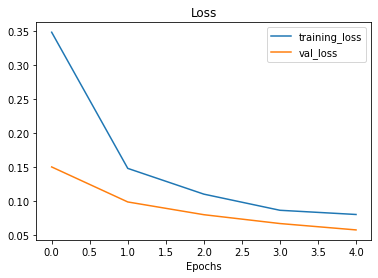

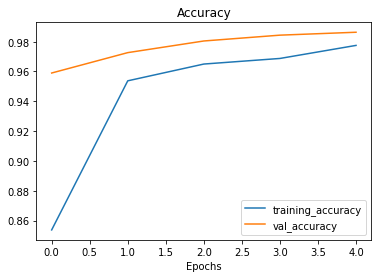

In [149]:
plot_loss_curves(history_1)

In [150]:
model_1_results = model_1.evaluate(test_data)

64/64 [==============================] - 4s 55ms/step - loss: 0.0623 - accuracy: 0.9812


## Model 2: Fine Tuning
EfficientNetB0 gives us great results right off the bat with data augmentation and with only 10% of the training data.

Now let's try to unfreeze 10% layers and train on our own custom data

In [151]:
base_model.trainable = True

# Freeze all layers except the last 10%
for layer in base_model.layers[:- int(.10 * len(base_model.layers))]:
  layer.trainable = False

Epoch 5/10
250/250 [==============================] - 25s 77ms/step - loss: 0.1348 - accuracy: 0.9520 - val_loss: 0.0714 - val_accuracy: 0.9844
Epoch 6/10
250/250 [==============================] - 18s 72ms/step - loss: 0.0750 - accuracy: 0.9706 - val_loss: 0.0202 - val_accuracy: 0.9941
Epoch 7/10
250/250 [==============================] - 18s 72ms/step - loss: 0.0611 - accuracy: 0.9761 - val_loss: 0.0840 - val_accuracy: 0.9844
Epoch 8/10
250/250 [==============================] - 18s 72ms/step - loss: 0.0551 - accuracy: 0.9799 - val_loss: 0.0601 - val_accuracy: 0.9883
Epoch 9/10
250/250 [==============================] - 19s 73ms/step - loss: 0.0568 - accuracy: 0.9791 - val_loss: 0.0625 - val_accuracy: 0.9863
Epoch 10/10
250/250 [==============================] - 18s 69ms/step - loss: 0.0462 - accuracy: 0.9839 - val_loss: 0.0627 - val_accuracy: 0.9844


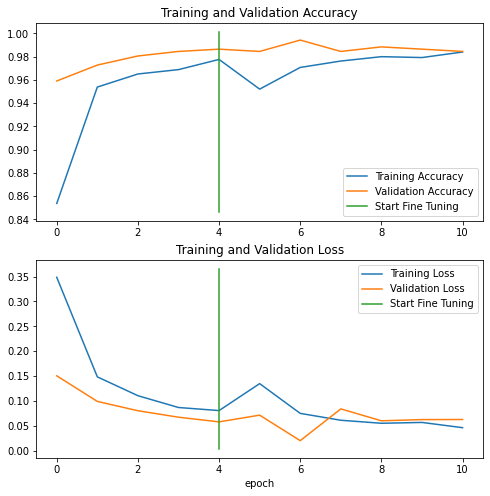

In [152]:
# # Create new model and recompile & fit
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_2 = model_2.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_1.epoch[-1]
)
compare_historys(history_1, history_2)

In [153]:
model_2_results = model_2.evaluate(test_data)

64/64 [==============================] - 4s 55ms/step - loss: 0.0364 - accuracy: 0.9862


**Summary:** EfficientNetB0 gave us a high accuracy score and the improvement from unfreezing layers is minimal.

# ResNet50V2

EfficientNetB0 proved to be usefull even before fine tuning, so let's try a different popular model to compare results

In [154]:
# Create New Checkpoint
checkpoint_path = 'resNet50V2/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [155]:
# Create base model
input_shape = (224, 224, 3)

resNet_model = tf.keras.applications.ResNet50V2(include_top=False)
resNet_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')


x = data_augmentation(inputs)

x = resNet_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(2, activation='softmax', name='output_layer')(x)



## Model 3

Epoch 1/5
25/25 [==============================] - 8s 175ms/step - loss: 160.2595 - accuracy: 0.5350 - val_loss: 103.5281 - val_accuracy: 0.4629
Epoch 2/5
25/25 [==============================] - 4s 146ms/step - loss: 43.4761 - accuracy: 0.5537 - val_loss: 41.0580 - val_accuracy: 0.4902
Epoch 3/5
25/25 [==============================] - 4s 146ms/step - loss: 31.7282 - accuracy: 0.5437 - val_loss: 35.3639 - val_accuracy: 0.5371
Epoch 4/5
25/25 [==============================] - 4s 135ms/step - loss: 26.8936 - accuracy: 0.5838 - val_loss: 59.6566 - val_accuracy: 0.4707
Epoch 5/5
25/25 [==============================] - ETA: 0s - loss: 20.9640 - accuracy: 0.5688
Epoch 5: saving model to resNet50V2/checkpoint.ckpt
INFO:tensorflow:Assets written to: resNet50V2/checkpoint.ckpt/assets
25/25 [==============================] - 24s 993ms/step - loss: 20.9640 - accuracy: 0.5688 - val_loss: 54.2239 - val_accuracy: 0.4707


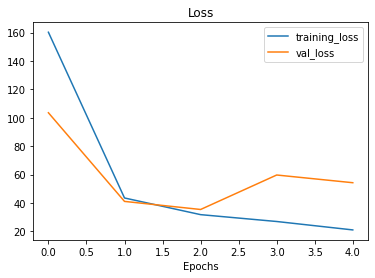

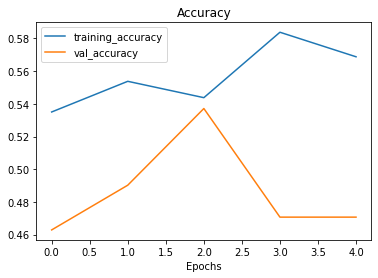

In [156]:
# Compile & Fit the model

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')
history_3 = model_3.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_3)

In [157]:
model_3_results = model_3.evaluate(test_data)

64/64 [==============================] - 4s 62ms/step - loss: 52.9491 - accuracy: 0.5000


Not very good results with ResNet50V2

Let's try unfreezing some layers and training on full test dataset to see if model improves

Let's try unlocking the last 10% of base layers

In [158]:
resNet_model.trainable = True

# Freeze all layers except the last 10%
for layer in resNet_model.layers[:- int(.10 * len(resNet_model.layers))]:
  layer.trainable = False



##Model 4

Epoch 5/10
250/250 [==============================] - 29s 102ms/step - loss: 1273802.6250 - accuracy: 0.5027 - val_loss: 0.6949 - val_accuracy: 0.4648
Epoch 6/10
250/250 [==============================] - 25s 99ms/step - loss: 0.6955 - accuracy: 0.5005 - val_loss: 0.6936 - val_accuracy: 0.4805
Epoch 7/10
250/250 [==============================] - 24s 96ms/step - loss: 0.6933 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.4707
Epoch 8/10
250/250 [==============================] - 24s 97ms/step - loss: 0.6965 - accuracy: 0.4976 - val_loss: 0.6947 - val_accuracy: 0.4629
Epoch 9/10
250/250 [==============================] - 25s 97ms/step - loss: 48.3863 - accuracy: 0.5002 - val_loss: 0.6939 - val_accuracy: 0.4746
Epoch 10/10
250/250 [==============================] - 25s 99ms/step - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6944 - val_accuracy: 0.4531


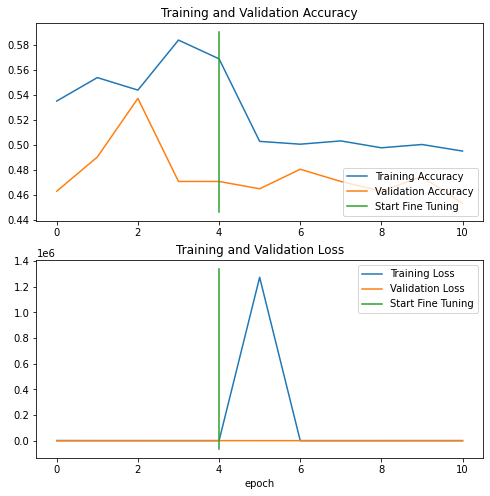

In [159]:
# # Create new model and recompile & fit
model_4 = tf.keras.Model(inputs, outputs)
model_4.load_weights(checkpoint_path)
model_4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_4 = model_4.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_3.epoch[-1]
)
compare_historys(history_3, history_4)




In [160]:
model_4_results = model_4.evaluate(test_data)

64/64 [==============================] - 4s 62ms/step - loss: 0.6932 - accuracy: 0.5000


Summary: ResNet50V2 did not perform nearly as well as efficientNetB0. Let's try one more model 

# Xception

In [161]:
# Create New Checkpoint
checkpoint_path = 'xception/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [162]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(2, activation='softmax', name='output_layer')(x)



## Model 5

Epoch 1/5
25/25 [==============================] - 9s 245ms/step - loss: 2.9347 - accuracy: 0.5225 - val_loss: 1.7480 - val_accuracy: 0.5605
Epoch 2/5
25/25 [==============================] - 5s 211ms/step - loss: 1.7965 - accuracy: 0.5550 - val_loss: 1.6173 - val_accuracy: 0.5977
Epoch 3/5
25/25 [==============================] - 5s 204ms/step - loss: 1.6064 - accuracy: 0.5612 - val_loss: 1.5434 - val_accuracy: 0.5996
Epoch 4/5
25/25 [==============================] - 5s 204ms/step - loss: 1.5470 - accuracy: 0.5537 - val_loss: 1.8335 - val_accuracy: 0.6016
Epoch 5/5
25/25 [==============================] - ETA: 0s - loss: 1.7782 - accuracy: 0.5275
Epoch 5: saving model to xception/checkpoint.ckpt
INFO:tensorflow:Assets written to: xception/checkpoint.ckpt/assets
25/25 [==============================] - 22s 881ms/step - loss: 1.7782 - accuracy: 0.5275 - val_loss: 1.6521 - val_accuracy: 0.5801


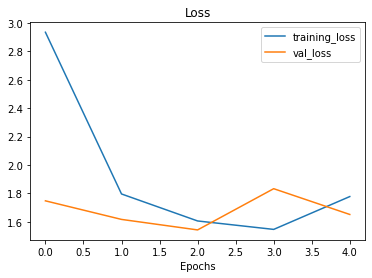

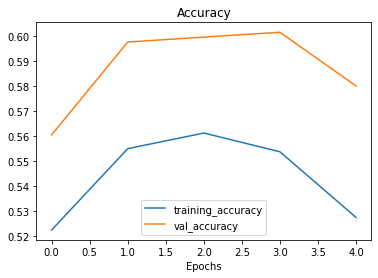

In [163]:
# Compile & Fit the model

model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_5 = model_5.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_5)

In [164]:
model_5_results = model_5.evaluate(test_data)

64/64 [==============================] - 6s 85ms/step - loss: 1.7025 - accuracy: 0.5589


## Model 6

In [165]:
xception_model.trainable = True

# Freeze all layers except the last 30%
for layer in xception_model.layers[:- int(.30 * len(xception_model.layers))]:
  layer.trainable = False



Epoch 5/10
250/250 [==============================] - 50s 185ms/step - loss: 5.3865 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5371
Epoch 6/10
250/250 [==============================] - 45s 179ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5254
Epoch 7/10
250/250 [==============================] - 44s 173ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6930 - val_accuracy: 0.5449
Epoch 8/10
250/250 [==============================] - 43s 171ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5254
Epoch 9/10
250/250 [==============================] - 43s 172ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 10/10
250/250 [==============================] - 40s 160ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5312


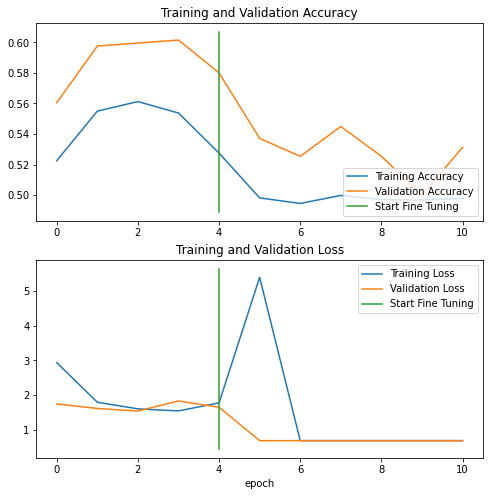

In [166]:
# # Create new model and recompile & fit
model_6 = tf.keras.Model(inputs, outputs)
model_6.load_weights(checkpoint_path)
model_6.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_6 = model_6.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_5.epoch[-1]
)
compare_historys(history_5, history_6)




In [167]:
model_6_results = model_6.evaluate(test_data)

64/64 [==============================] - 6s 84ms/step - loss: 0.6931 - accuracy: 0.5000


`Exception` gave us horrible results when unfreezing layers to train on custom data_augmentation
Just to make sure let's create a new xception model and evaluate the data without fitting to see if we could have gotten a better score


## Model 7


In [168]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(2, activation='softmax', name='output_layer')(x)



In [169]:
# Compile & Fit the model

model_7 = tf.keras.Model(inputs, outputs)
model_7.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_7_results = model_7.evaluate(test_data)


64/64 [==============================] - 7s 84ms/step - loss: 2.2300 - accuracy: 0.5460


In [170]:
model_7_results[1], model_6_results[1]

(0.5459940433502197, 0.5)

Summary: When comparing `model_6` which is trained on custom data and `model_7` which is not trained on custom data, we see that they both perform the same at `~0.5` accuracy

 # Comparing models 

In [171]:
import pandas as pd
models = [
          model_1_results,
          model_2_results,
          model_3_results,
          model_4_results,
          model_5_results,
          model_6_results,
          model_7_results,
]


results = pd.DataFrame(models, columns=['loss', 'accuracy'])
results

,loss,accuracy
0,0.062276,0.981207
1,0.036441,0.986152
2,52.949055,0.500000
3,0.693221,0.500000
4,1.702467,0.558853
5,0.693148,0.500000
6,2.230036,0.545994


Summary: As we can see, the first 2 models performed the best which run off of EfficientNetB0 and our fine tuned model [2] has the highest accuracy score
Lets's use model_2 to make predictions


# Predictions: EfficientNetB0 Model 2

In [173]:
# upload file(s)
from google.colab import files

uploaded = files.upload()


Saving nugget.jpg to nugget (1).jpg
Saving ashley.jpg to ashley (1).jpg


In [ ]:
from IPython.display import Image
Image(filename='nugget.jpg', width=500, height=300)

In [174]:
import numpy as np
from tensorflow.keras.preprocessing import image
def prepare_image(file):
  img = image.load_img(file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.efficientnet.preprocess_input(img_array_expanded_dims)

In [194]:
results = model_2.predict(prepare_image('/content/images/test/dogs/dog.4015.jpg'), verbose=1)
results

1/1 [==============================] - 0s 25ms/step


array([[0.00184338, 0.9981566 ]], dtype=float32)

In [195]:
results, np.argmax(results, axis=1)

(array([[0.00184338, 0.9981566 ]], dtype=float32), array([1]))

In [186]:
test_data.class_names

['cats', 'dogs']